## Sim Demo

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from env.imports import *

/ext3/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-05-20 23:13:13.610918: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 23:13:15.514315: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-20 23:13:17.202337: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  import numpy.matlib 

In [3]:
import importlib
import data

import models
import sim.sim
import sim.sim_utils
from sim.sim_utils import bytes2human, print_system_usage
from sim.sim import Simulation
from sim.sim_run import single_sim_run

importlib.reload(sim.sim)
importlib.reload(sim.sim_run) 

absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn
absolute_root_path /scratch/asr655/neuroinformatics/GeneEx2Conn


<module 'sim.sim_run' from '/scratch/asr655/neuroinformatics/GeneEx2Conn/sim/sim_run.py'>

#### Check job specs

In [4]:
print_system_usage()

total = psutil.disk_usage('/').total
print(bytes2human(total))

CPU Usage: 11.4%
RAM Usage: 4.0%
Available RAM: 1.4T
Total RAM: 1.5T
52.4G


In [5]:
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

# Check available GPUs
print(f"Available GPUs: {torch.cuda.device_count()}")

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)} - Memory Allocated: {torch.cuda.memory_allocated(i)/1024**3:.2f} GB")


None
Available GPUs: 1
GPU 0: NVIDIA H100 80GB HBM3 - Memory Allocated: 0.00 GB


In [6]:
print("XGBoost version:", xgboost.__version__)
print("cupy version:", cp.__version__)

GPUtil.getAvailable()

# if a number is seen a GPU is available
GPUtil.getGPUs()

DEVICE_ID_LIST = GPUtil.getFirstAvailable()
DEVICE_ID = DEVICE_ID_LIST[0] # grab first element from list
if DEVICE_ID != None: 
    print('GPU found', DEVICE_ID)
    use_gpu = True

    GPUtil.showUtilization()

XGBoost version: 2.0.3
cupy version: 13.1.0
GPU found 0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [7]:
torch.cuda.is_available()

# Clear GPU memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Simulation tests <a id="sims"></a>

Attention heads

In [8]:
from models.base_models import ModelBuild, BaseModel
from models.bilinear import BilinearLowRank, BilinearCM
from models.pls import PLSTwoStepModel, PLS_MLPDecoderModel, PLS_BilinearDecoderModel
from models.dynamic_mlp import DynamicMLP
from models.shared_encoder_models import SharedMLPEncoderModel, SharedLinearEncoderModel
from models.transformer_models import SharedSelfAttentionModel, SharedSelfAttentionCLSModel, CrossAttentionModel

from data.data_load import load_transcriptome, load_connectome, load_coords, load_network_labels
from data.data_viz import plot_connectome, plot_transcriptome
from data.data_utils import expand_X_symmetric, expand_Y_symmetric

from data.data_utils import RegionPairDataset
from torch.utils.data import Subset



In [9]:
# Load data
print("Loading data...")
X = load_transcriptome(parcellation='S400', hemisphere='both', omit_subcortical=False, sort_genes='chromosome', impute_strategy='mirror_interpolate')
Y = load_connectome(parcellation='S400', hemisphere='both', omit_subcortical=False)
coords = load_coords(parcellation='S400', hemisphere='both', omit_subcortical=False)
labels, network_labels = load_network_labels(parcellation='S400', hemisphere='both', omit_subcortical=False)

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Create index map so we know true indices of valid data
valid_indices_values = np.where(valid_indices)[0]
valid2true_mapping = dict(enumerate(valid_indices_values))

# Subset all data using valid indices
X_valid = X[valid_indices]
Y_valid = Y[valid_indices][:, valid_indices]
coords_valid = coords[valid_indices]
labels = [labels[i] for i in range(len(labels)) if valid_indices[i]]
network_labels = network_labels[valid_indices]

# Create full region pair dataset
print("Creating RegionPairDataset...")
dataset = RegionPairDataset(
    X=X_valid,
    Y=Y_valid,
    coords=coords_valid,
    valid2true_mapping=valid2true_mapping
)

batch_size = 512
# Create dataloader with all pairs
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True  # Speed up data transfer to GPU
)

Loading data...
Creating RegionPairDataset...


In [10]:
from models.transformer_models import SharedSelfAttentionCLSModel

# Set up base model with the same hyperparameters used for training
smt_base_model = SharedSelfAttentionModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_base_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_base_full.pt"))
smt_base_model.eval()
smt_base_model.to("cuda")


# Set up model with the same hyperparameters used for training
smt_cls_model = SharedSelfAttentionCLSModel(
    input_dim=14760,   # should be 2 * num_genes
    token_encoder_dim=60,
    d_model=128,
    encoder_output_dim=10,
    nhead=4,
    num_layers=4,
    cls_init='spatial_learned',
    use_alibi=True,
    dropout_rate=0.2,
    transformer_dropout=0.2,
    aug_prob=0.0,
    binarize=False
)

# Load saved weights
smt_cls_model.load_state_dict(torch.load("/scratch/asr655/neuroinformatics/GeneEx2Conn/models/saved_models/UKBB_cls_full.pt"))
smt_cls_model.eval()
smt_cls_model.to("cuda")


  warnings.warn(



SharedSelfAttentionCLSModel(
  (encoder): OptimizedModule(
    (_orig_mod): SelfAttentionCLSEncoder(
      (input_projection): Linear(in_features=60, out_features=128, bias=True)
      (coord_to_cls): Linear(in_features=3, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x FastSelfAttentionBlock(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (attn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ffn): Sequential(
            (0): Linear(in_features=128, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=128, bias=True)
            (3): Dropout(p=0.2, inplace=False)
          )
          (ffn_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
      )
      (output_projection): Linear(in_features=128, out_features=10, bias=True)
    )
  )
  (deep_layers): Sequential(
    (

In [11]:
print(f"Dataset size: {len(dataset)}")


Dataset size: 206570


In [12]:
from torch.utils.data import Subset

subset_indices = list(range(206570))
#subset_indices = list(range(1024))

subset_dataset = Subset(dataset, subset_indices)

subset_loader = DataLoader(
    subset_dataset,
    batch_size=1024,
    shuffle=False,
    num_workers=6,
    pin_memory=True
)

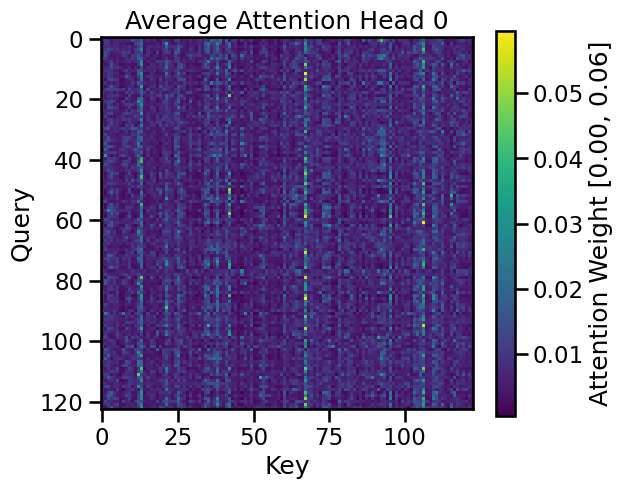

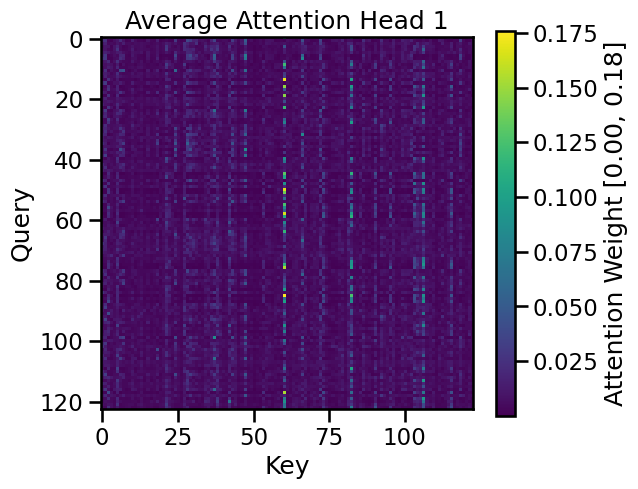

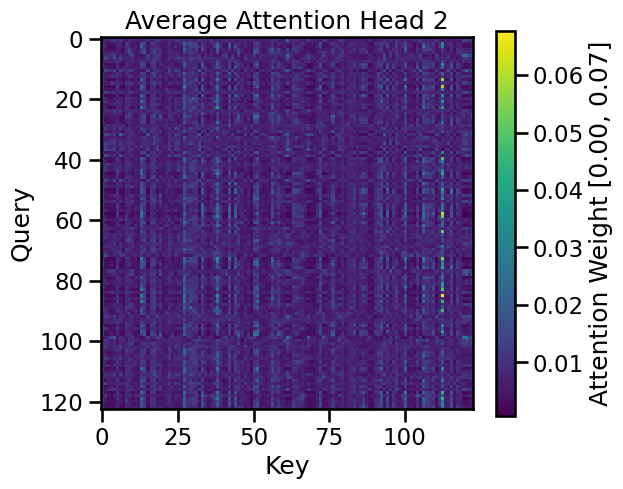

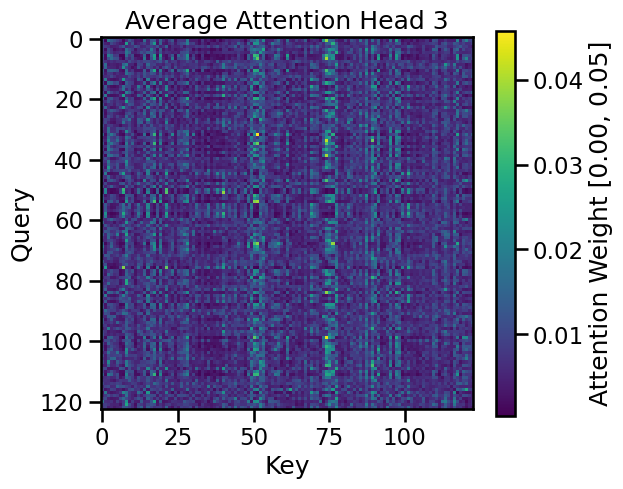

In [20]:
predictions, targets = smt_base_model.predict(subset_loader, collect_attn=True, save_attn_path='attn_base_SMT_full_training.npy')

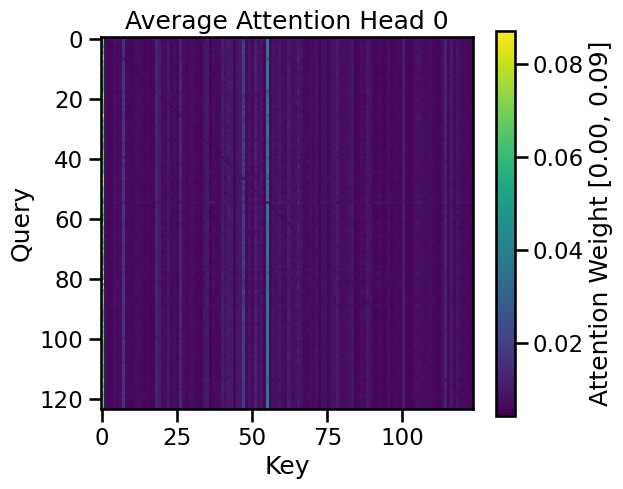

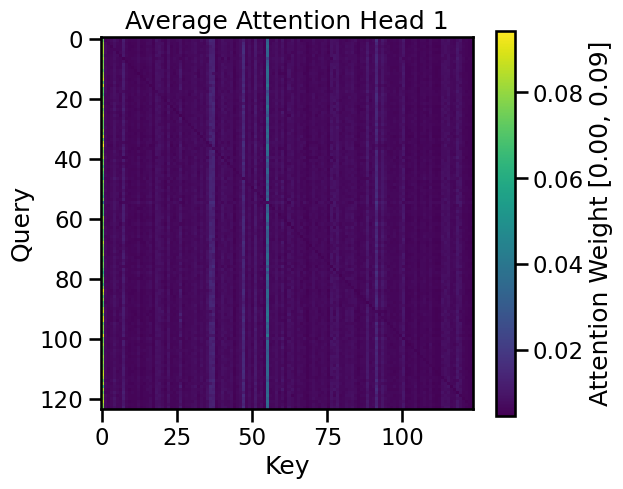

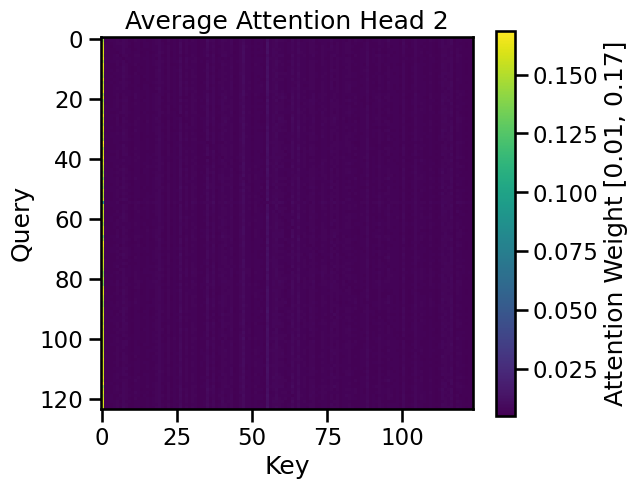

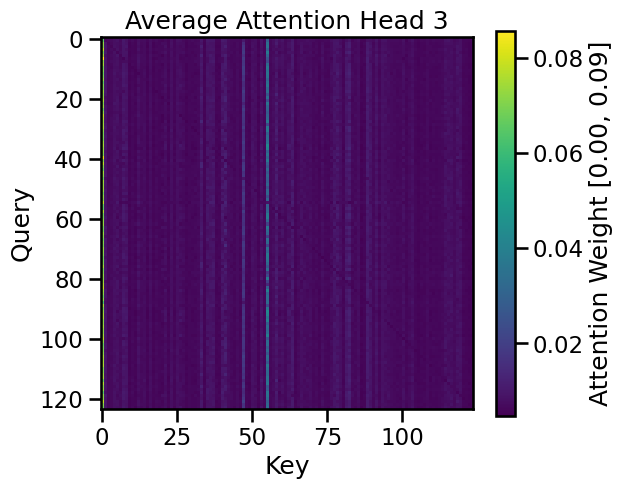

In [13]:
predictions, targets = smt_cls_model.predict(subset_loader, collect_attn=True, save_attn_path='attn_cls_SMT_full_training.npy')

In [23]:
# Get valid genes from load_transcriptome
from data.data_load import load_transcriptome

X, valid_genes = load_transcriptome(parcellation='S400', gene_list='0.2', dataset='AHBA', run_PCA=False, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='refgenome', return_valid_genes=True, null_model='none', random_seed=42)

# Get reference genome info for valid genes
refgenome = pd.read_csv('./data/enigma/gene_lists/human_refgenome_ordered.csv')
valid_refgenome = refgenome[refgenome['gene_id'].isin(valid_genes)]

# Create gene groups/tokens
token_chunk_size = 60
num_tokens = len(valid_refgenome) // token_chunk_size
gene_tokens = []

for i in range(num_tokens):
    start_idx = i * token_chunk_size
    end_idx = start_idx + token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:end_idx]
    
    # Get unique chromosome for this token
    chrom = token_genes['chromosome'].iloc[0]
    
    token = {
        'token_id': i,
        'genes': token_genes['gene_id'].tolist(),
        'chromosome': chrom
    }
    gene_tokens.append(token)

# Handle remaining genes if any
remaining_genes = len(valid_refgenome) % token_chunk_size
if remaining_genes > 0:
    start_idx = num_tokens * token_chunk_size
    token_genes = valid_refgenome.iloc[start_idx:]
    token = {
        'token_id': num_tokens,
        'genes': token_genes['gene_id'].tolist(), 
        'chromosome': token_genes['chromosome'].iloc[0]
    }
    gene_tokens.append(token)


valid genes ['LOC729737', 'LINC01128', 'SAMD11', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'TNFRSF4', 'B3GALT6', 'ACAP3', 'PUSL1', 'DVL1', 'MXRA8', 'CCNL2', 'ANKRD65', 'FNDC10', 'CDK11A', 'GABRD', 'RER1', 'PEX10', 'PLCH2', 'HES5', 'TNFRSF14', 'ARHGEF16', 'TPRG1L', 'AJAP1', 'TNFRSF25', 'PLEKHG5', 'NOL9', 'PHF13', 'CAMTA1', 'PER3', 'ERRFI1', 'SLC45A1', 'ENO1', 'SLC2A5', 'SPSB1', 'TMEM201', 'PIK3CD', 'CLSTN1', 'CTNNBIP1', 'UBE4B', 'PGD', 'TARDBP', 'MASP2', 'SRM', 'FBXO2', 'FBXO44', 'DRAXIN', 'CLCN6', 'NPPA', 'NPPB', 'VPS13D', 'DHRS3', 'LRRC38', 'PDPN', 'PRDM2', 'KAZN', 'EFHD2', 'AGMAT', 'PLEKHM2', 'SLC25A34', 'UQCRHL', 'SRARP', 'SZRD1', 'CROCCP2', 'SDHB', 'RCC2', 'ARHGEF10L', 'IGSF21', 'ALDH4A1', 'IFFO2', 'MRTO4', 'AKR7L', 'AKR7A3', 'AKR7A2', 'CAPZB', 'UBXN10', 'CAMK2N1', 'FAM43B', 'PINK1', 'KIF17', 'SH2D5', 'NBPF3', 'ALPL', 'RAP1GAP', 'CDC42', 'WNT4', 'ZBTB40', 'C1QA', 'C1QC', 'C1QB', 'EPHB2', 'LUZP1', 'ZNF436', 'ZNF436-AS1', 'TCEA3', 'ASAP3', 'HMGCL', 'IFNLR1', 'STPG1', 'NIPAL3', 'RCAN3', 'SYF2

In [27]:
gene_tokens[56]

{'token_id': 56,
 'genes': ['GPAA1',
  'CYC1',
  'WDR97',
  'HGH1',
  'SCX',
  'SCRT1',
  'TMEM249',
  'ADCK5',
  'CPSF1',
  'SLC39A4',
  'KIFC2',
  'LRRC14',
  'ARHGAP39',
  'ZNF34',
  'ZNF7',
  'ZNF250',
  'CBWD1',
  'DOCK8',
  'KANK1',
  'DMRT2',
  'VLDLR',
  'RFX3',
  'GLIS3',
  'AK3',
  'RCL1',
  'JAK2',
  'CD274',
  'ERMP1',
  'IL33',
  'UHRF2',
  'GLDC',
  'KDM4C',
  'PTPRD-AS1',
  'TYRP1',
  'LURAP1L',
  'NFIB',
  'ZDHHC21',
  'LOC389705',
  'TTC39B',
  'PSIP1',
  'CCDC171',
  'CNTLN',
  'ADAMTSL1',
  'SLC24A2',
  'FOCAD',
  'HACD4',
  'KLHL9',
  'MTAP',
  'CDKN2A',
  'CAAP1',
  'IFT74',
  'TEK',
  'LINGO2',
  'ACO1',
  'DDX58',
  'TOPORS',
  'NDUFB6',
  'TMEM215',
  'DNAJA1',
  'CHMP5'],
 'chromosome': 'NC_000008.11'}